In [ ]:
import pandas as pd

#Sample knowledge base for fashion products
product_knowledgebase = [
    {"name": "Boho Dress", "desc": "Flowy, earthy tones, loose fit for festival comfort and nature vibes.", "tags": ["boho", "nature", "cozy"]},
    {"name": "Techwear Jacket", "desc": "Highly durable, sleek black design, water-resistant for urban exploration.", "tags": ["urban", "tech", "futuristic"]},
    {"name": "Cashmere Sweater", "desc": "Soft, luxurious, neutral color, perfect for a cozy night by the fireplace.", "tags": ["cozy", "luxury", "classic"]},
    {"name": "Neon Athletic Set", "desc": "Bright, vibrant colors, compression material for high-energy workouts.", "tags": ["energetic", "sporty", "bold"]},
    {"name": "Vintage Denim", "desc": "Straight leg, light wash, slightly distressed for a relaxed, timeless look.", "tags": ["classic", "relaxed", "vintage"]},
    {"name": "Business Blazer", "desc": "Structured, navy blue, sharp cut for professional, serious meetings.", "tags": ["formal", "sharp", "professional"]},
    {"name": "Plaid Flannel Shirt", "desc": "Thick cotton, red and black pattern, rugged and warm for outdoor activities.", "tags": ["cozy", "rugged", "casual"]},
]

df = pd.DataFrame(product_knowledgebase)
print("DataFrame is created successfully...")

DataFrame is created successfully...


In [10]:
import os
import numpy as np
from sentence_transformers import SentenceTransformer

# Use local, free, high-quality embedding model
MODEL_NAME = "all-MiniLM-L6-v2"
model = SentenceTransformer(MODEL_NAME)

def embed_texts(texts):
    texts = [t.replace("\n", " ") for t in texts]
    return model.encode(texts, convert_to_numpy=True, normalize_embeddings=True).astype(np.float32)

item_vecs = embed_texts(df["desc"].tolist())
print(f"Embeddings created using {MODEL_NAME}: {item_vecs.shape}")


Embeddings created using all-MiniLM-L6-v2: (7, 384)


In [14]:
from sklearn.metrics.pairwise import cosine_similarity

def jaccard(a, b):
    sa, sb = set(map(str.lower, a)), set(map(str.lower, b))
    return len(sa & sb) / max(1, len(sa | sb))

def rank(query, top_k=3, vibe_boost=0.15):
    qv = embed_texts([query])
    sims = cosine_similarity(qv, item_vecs)[0]
    qtags = [t.strip(",.!?-").lower() for t in query.split() if len(t) > 2]
    results = []
    for i, row in df.iterrows():
        cos_sim = sims[i]
        vibe_sim = jaccard(qtags, row["tags"])
        combined = (1 - vibe_boost) * cos_sim + vibe_boost * vibe_sim
        results.append({
            "rank": i + 1,
            "name": row["name"],
            "combined_score": round(combined, 4),
            "cosine_sim": round(cos_sim, 4),
            "vibe_overlap": round(vibe_sim, 4)
        })
    results.sort(key=lambda x: x["combined_score"], reverse=True)
    return results[:top_k]



Evaluation Summary:
                      query          top_match  best_score  good@0.7  \
0     energetic urban chic  Neon Athletic Set      0.2978     False   
1  cozy minimalist neutral   Cashmere Sweater      0.3978     False   
2    vintage boho festival         Boho Dress      0.1952     False   

   latency_ms  
0       16.53  
1       14.00  
2       14.03  


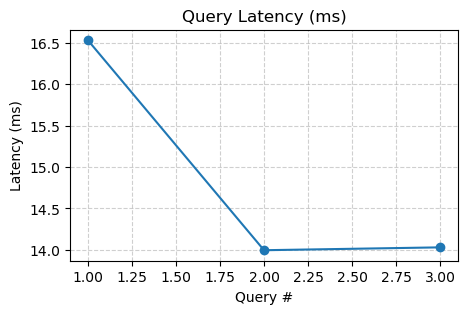

In [15]:
import time, pandas as pd, matplotlib.pyplot as plt

queries = ["energetic urban chic", "cozy minimalist neutral", "vintage boho festival"]
rows, times = [], []

for q in queries:
    t0 = time.perf_counter()
    res = rank(q)
    dt = (time.perf_counter() - t0) * 1000
    best = res[0]["combined_score"]
    times.append(dt)
    rows.append({
        "query": q,
        "top_match": res[0]["name"],
        "best_score": best,
        "good@0.7": best >= 0.7,
        "latency_ms": round(dt, 2)
    })

eval_df = pd.DataFrame(rows)
print("\nEvaluation Summary:\n", eval_df)

plt.figure(figsize=(5, 3))
plt.title("Query Latency (ms)")
plt.plot(range(1, len(times) + 1), times, marker="o", linestyle="-")
plt.xlabel("Query #")
plt.ylabel("Latency (ms)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
